# Import Libraries

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from model import Model_GN
%matplotlib inline

In [ ]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Data Statistics

In [ ]:
simple_transforms = transforms.Compose([transforms.ToTensor()])
exp_train = datasets.CIFAR10('./data', train=True, download=True)
exp_test = datasets.CIFAR10('./data', train=True, download=False)
exp_train_data = exp_train.data
exp_test_data = exp_test.data
exp_data = np.concatenate((exp_train_data, exp_test_data), axis=0)

print(f'Shape: {exp_data.shape}')
print(f'Mean: {exp_data.mean(axis=(0,1,2))/255}')
print(f'STD: {exp_data.std(axis=(0,1,2))/255}')

Files already downloaded and verified
Shape: (100000, 32, 32, 3)
Mean: [0.49139968 0.48215841 0.44653091]
STD: [0.24703223 0.24348513 0.26158784]


# Initialize train and test transforms

In [ ]:
# Training transform
train_transforms = transforms.Compose([transforms.RandomApply([transforms.RandAugment()], p=0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])])

# Test transform
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])])

# transform to inverse effect of Normalization while ploting
inv_transform = transforms.Normalize([-0.49139968/0.24703223, -0.48215841/0.24348513, -0.44653091/0.26158784], [1/0.24703223, 1/0.24348513, 1/0.26158784])

# Download data

In [ ]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Create data loader

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Plot data

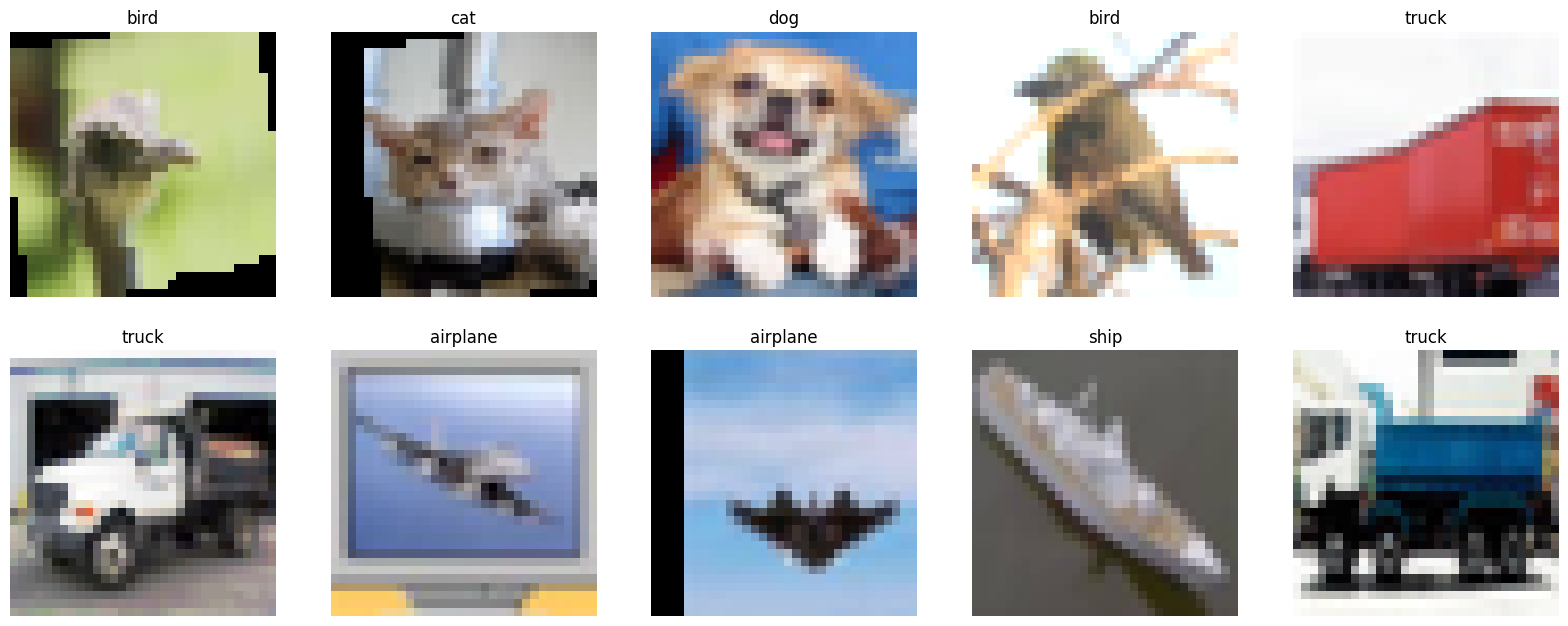

In [ ]:
figure = plt.figure(figsize=(20,20))
num_of_images = 10
images, labels = next(iter(train_loader))
images = inv_transform(images)
for index in range(1, num_of_images + 1):
    plt.subplot(5, 5, index)
    plt.title(CLASS_NAMES[labels[index].numpy()])
    plt.axis('off')
    plt.imshow(np.transpose(images[index], (1, 2, 0)))

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_GN().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         GroupNorm-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
         GroupNorm-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             128
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           2,304
        GroupNorm-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
          Dropout-14           [-1

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Model_GN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


EPOCH: 0


Loss=1.774921178817749 Batch_id=390 Accuracy=22.40: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 1.7767, Accuracy: 3279/10000 (32.79%)

EPOCH: 1


Loss=1.3098466396331787 Batch_id=390 Accuracy=37.73: 100%|██████████| 391/391 [00:25<00:00, 15.46it/s]



Test set: Average loss: 1.5111, Accuracy: 4416/10000 (44.16%)

EPOCH: 2


Loss=1.4859708547592163 Batch_id=390 Accuracy=43.68: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s]



Test set: Average loss: 1.4286, Accuracy: 4684/10000 (46.84%)

EPOCH: 3


Loss=1.080165147781372 Batch_id=390 Accuracy=48.95: 100%|██████████| 391/391 [00:25<00:00, 15.40it/s]



Test set: Average loss: 1.3006, Accuracy: 5293/10000 (52.93%)

EPOCH: 4


Loss=1.1110007762908936 Batch_id=390 Accuracy=53.02: 100%|██████████| 391/391 [00:25<00:00, 15.05it/s]



Test set: Average loss: 1.1915, Accuracy: 5715/10000 (57.15%)

EPOCH: 5


Loss=1.1872987747192383 Batch_id=390 Accuracy=56.65: 100%|██████████| 391/391 [00:25<00:00, 15.56it/s]



Test set: Average loss: 1.0649, Accuracy: 6186/10000 (61.86%)

EPOCH: 6


Loss=1.0801013708114624 Batch_id=390 Accuracy=60.06: 100%|██████████| 391/391 [00:25<00:00, 15.42it/s]



Test set: Average loss: 1.0083, Accuracy: 6305/10000 (63.05%)

EPOCH: 7


Loss=1.0621812343597412 Batch_id=390 Accuracy=62.14: 100%|██████████| 391/391 [00:24<00:00, 15.68it/s]



Test set: Average loss: 1.0025, Accuracy: 6347/10000 (63.47%)

EPOCH: 8


Loss=1.0435097217559814 Batch_id=390 Accuracy=64.17: 100%|██████████| 391/391 [00:26<00:00, 14.75it/s]



Test set: Average loss: 0.9612, Accuracy: 6648/10000 (66.48%)

EPOCH: 9


Loss=1.0377380847930908 Batch_id=390 Accuracy=65.79: 100%|██████████| 391/391 [00:25<00:00, 15.15it/s]



Test set: Average loss: 0.9398, Accuracy: 6650/10000 (66.50%)

EPOCH: 10


Loss=0.7300301790237427 Batch_id=390 Accuracy=70.32: 100%|██████████| 391/391 [00:25<00:00, 15.33it/s]



Test set: Average loss: 0.8193, Accuracy: 7127/10000 (71.27%)

EPOCH: 11


Loss=0.6806530356407166 Batch_id=390 Accuracy=70.93: 100%|██████████| 391/391 [00:25<00:00, 15.31it/s]



Test set: Average loss: 0.8121, Accuracy: 7139/10000 (71.39%)

EPOCH: 12


Loss=0.9216537475585938 Batch_id=390 Accuracy=71.19: 100%|██████████| 391/391 [00:25<00:00, 15.62it/s]



Test set: Average loss: 0.8088, Accuracy: 7158/10000 (71.58%)

EPOCH: 13


Loss=0.9030541181564331 Batch_id=390 Accuracy=71.45: 100%|██████████| 391/391 [00:25<00:00, 15.32it/s]



Test set: Average loss: 0.8001, Accuracy: 7207/10000 (72.07%)

EPOCH: 14


Loss=0.6846243739128113 Batch_id=390 Accuracy=71.77: 100%|██████████| 391/391 [00:25<00:00, 15.14it/s]



Test set: Average loss: 0.7924, Accuracy: 7209/10000 (72.09%)

EPOCH: 15


Loss=0.9531210064888 Batch_id=390 Accuracy=71.81: 100%|██████████| 391/391 [00:25<00:00, 15.46it/s]



Test set: Average loss: 0.7863, Accuracy: 7248/10000 (72.48%)

EPOCH: 16


Loss=0.7283268570899963 Batch_id=390 Accuracy=72.11: 100%|██████████| 391/391 [00:25<00:00, 15.40it/s]



Test set: Average loss: 0.7763, Accuracy: 7245/10000 (72.45%)

EPOCH: 17


Loss=0.8204174041748047 Batch_id=390 Accuracy=72.14: 100%|██████████| 391/391 [00:24<00:00, 15.70it/s]



Test set: Average loss: 0.7582, Accuracy: 7348/10000 (73.48%)

EPOCH: 18


Loss=0.786891758441925 Batch_id=390 Accuracy=72.33: 100%|██████████| 391/391 [00:26<00:00, 14.71it/s]



Test set: Average loss: 0.7847, Accuracy: 7245/10000 (72.45%)

EPOCH: 19


Loss=0.8045555949211121 Batch_id=390 Accuracy=72.71: 100%|██████████| 391/391 [00:25<00:00, 15.33it/s]



Test set: Average loss: 0.7954, Accuracy: 7217/10000 (72.17%)



Text(0.5, 1.0, 'Test Accuracy')

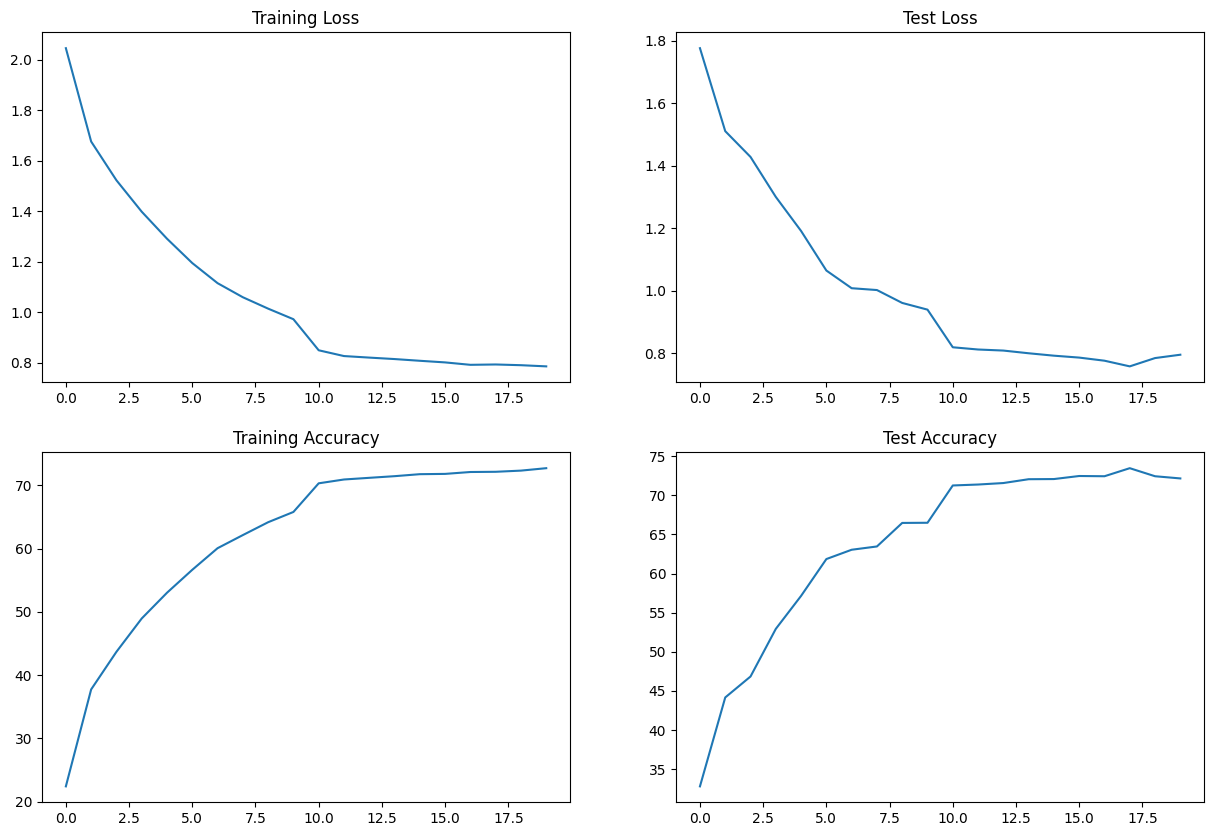

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
def plot_missclassified_images(model, test_loader):
  model.eval()

  missclassified_image_list = []
  label_list = []
  pred_list = []

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)
      if len(missclassified_image_list) > 10:
        break
      for i in range(len(pred)):
        if pred[i] != target[i]:
          missclassified_image_list.append(data[i])
          label_list.append(CLASS_NAMES[target[i]])
          pred_list.append(CLASS_NAMES[pred[i]])

  figure = plt.figure(figsize=(20,20))
  num_of_images = 10
  for index in range(1, num_of_images + 1):
      plt.subplot(5, 5, index)
      plt.title(f'Actual: {label_list[index]} Prediction: {pred_list[index]}')
      plt.axis('off')
      image = inv_transform(missclassified_image_list[index])
      plt.imshow(np.transpose(image.cpu(), (1, 2, 0)))

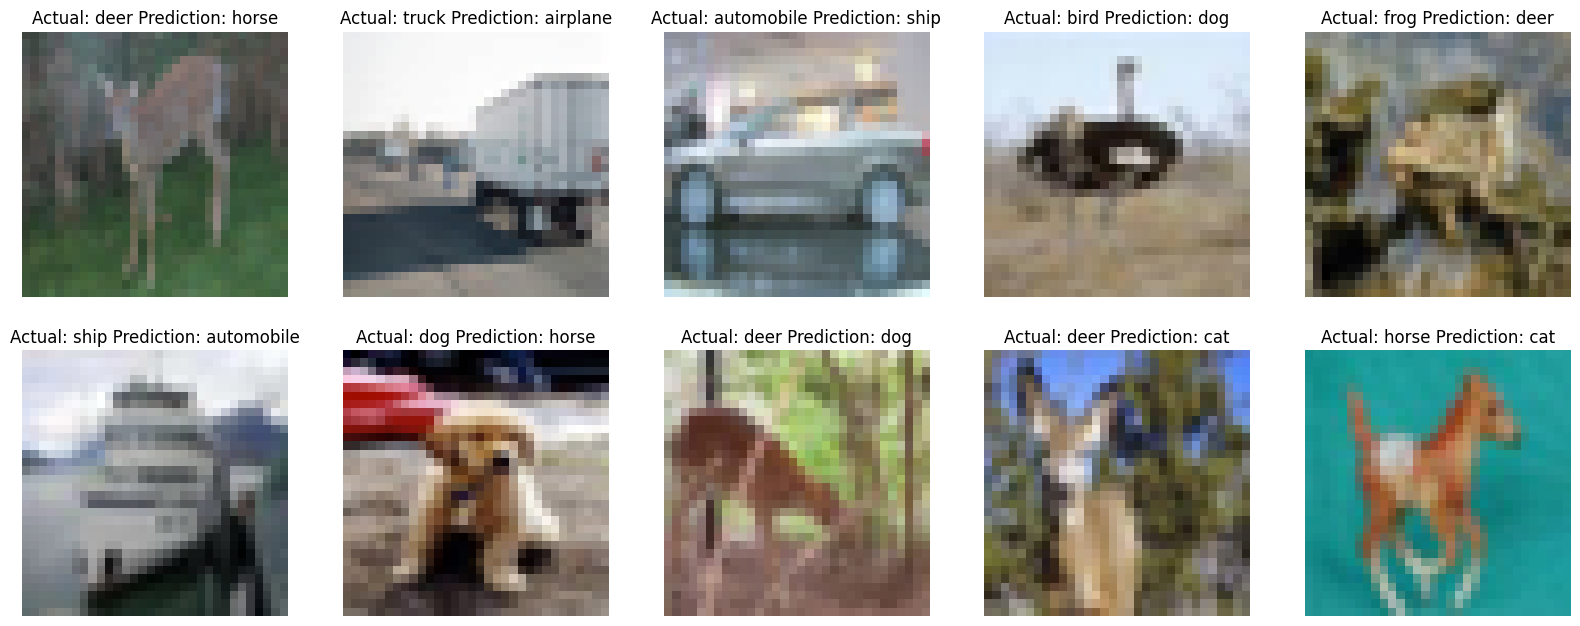

In [ ]:
plot_missclassified_images(model, test_loader)